# **Pneumonia Detection AI using Deep Learning**
<p>This IPYNB file presents an AI system for the detection of pneumonia using deep learning techniques. Pneumonia is a serious medical condition that affects millions of people worldwide, and early and accurate diagnosis is critical for successful treatment. Traditional methods for detecting pneumonia, such as X-rays, can be time-consuming and require expert interpretation, leading to delays in diagnosis and treatment.</p>
<p>The proposed AI system uses a convolutional neural network (CNN) to analyze chest X-rays and identify signs of pneumonia. The model is trained on a large dataset of X-ray images and is capable of accurately detecting the disease with high precision. The system is also able to analyze images quickly and can provide a diagnosis in a matter of seconds.</p>
<p>This IPYNB file covers the following topics:</p>
<ul>
<li>Data preparation and pre-processing</li>
<li>Building and training the CNN model</li>
<li>Evaluating model performance using metrics such as precision, recall, and F1 score</li>
<li>Deploying the trained model for pneumonia detection in new X-ray images</li>
</ul>
<p>The AI system has the potential to revolutionize the way pneumonia is diagnosed and treated, particularly in resource-limited settings where access to expert radiologists may be limited. By enabling early and accurate diagnosis, the system can help to reduce the burden of pneumonia and save lives.</p>
<p>Overall, this IPYNB file provides an overview of how an AI system can be built and deployed for pneumonia detection using deep learning techniques. The file can be used as a starting point for developers and researchers interested in developing similar AI systems for medical diagnosis and treatment.</p>

## **Importing required libraries**

In [205]:

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import glob
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import cv2 as cv
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split



# Directories of training , testing & validation data

In [206]:
input_data="chest_Xray/"
train_directory= input_data + "train/"
val_directory= input_data + "val/"
test_directory= input_data + "test/"

# **Getting the class names**

In [207]:
data_dir = train_directory
class_names=os.listdir(train_directory)
print(class_names)

['NORMAL', 'PNEUMONIA']


# **Define Constantes**

In [208]:
# dir to generate files
FILES_GENERATED = 'files_generated/'
# name of model to save to png file
MODEL_PNG = 'cnn_model.png'
#checkpoint dir
CHECKPOINT_DIR = 'checkpoints/'
# name of best model to save
MODEL_SAVED = 'saved_model/model.h5'
# Default batch size
BATCH_SIZE = 32
# Image size
IMAGE_SIZE = 224

# **Random vizualization from all directories**

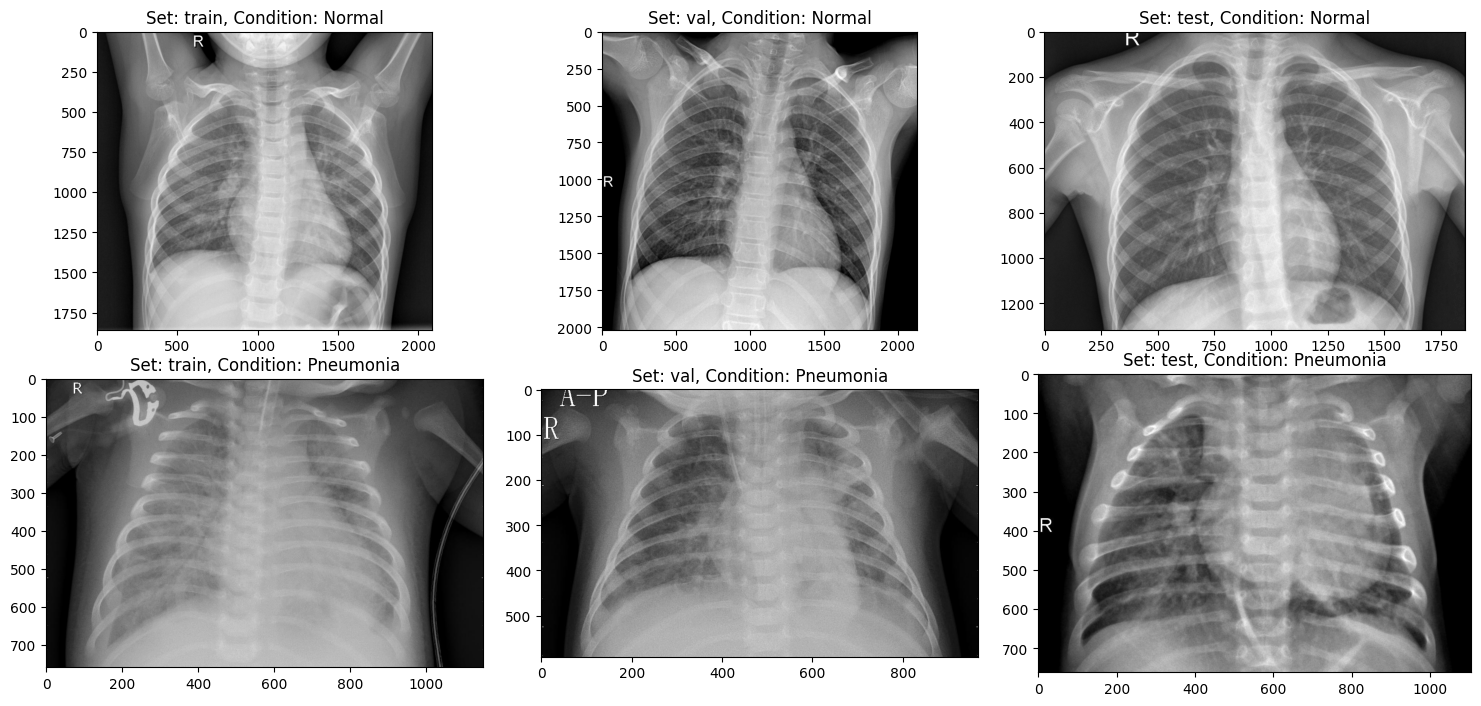

In [209]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_data + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

# **No. of images present in each set**

In [210]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_data + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_data + _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, Normal images: 1341, pneumonia images: 3875
Set: val, Normal images: 9, pneumonia images: 8
Set: test, Normal images: 234, pneumonia images: 390


# **Keras ImageDataGenerator**

<p> It is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed. It does not add the data. Keras image data generator class is also used to carry out data augmentation where we aim to gain the overall increment in the generalization of the model. Operations such as rotations, translations, shearin, scale changes, and horizontal flips are carried out randomly in data augmentation using an image data generator. </p>

![ImageDataGenerator](http://ai.stanford.edu/blog/assets/img/posts/2020-04-20-data-augmentation/fig1.png)

### This is how it looks like
![ImageDataGenerator_sample](https://miro.medium.com/max/1200/1*Ukc49J8TzyxiOD30EqOWwQ.png)


In [211]:
Image_gen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest',
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255,
)

# **Flow from directory**

<p> This method is useful when the images are sorted and placed in there respective class/label folders. This method will identify classes automatically from the folder name. </p> 

![Flow from directory](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*HpvpA9pBJXKxaPCl5tKnLg.jpeg)

In [212]:
train = Image_gen.flow_from_directory(
    train_directory,
    batch_size=32,
    class_mode='binary',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )

validation = Image_gen.flow_from_directory(
    val_directory,
    batch_size=2,                                              
    class_mode='binary',
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )

test = val_Datagen.flow_from_directory(
    test_directory,
    batch_size=2,
    class_mode='binary',     
    target_size=(IMAGE_SIZE, IMAGE_SIZE)                    
    )

Found 5216 images belonging to 2 classes.
Found 17 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [213]:
img, label = next(train)

# **Early Stopping callback** 

<p> In machine learning, early stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration. Up to a point, this improves the learner's performance on data outside of the training set. Past that point, however, improving the learner's fit to the training data comes at the expense of increased generalization error. Early stopping rules provide guidance as to how many iterations can be run before the learner begins to over-fit. Early stopping rules have been employed in many different machine learning methods, with varying amounts of theoretical foundation. </p>

![Early stopping](https://i.stack.imgur.com/LY2wM.png)

In [214]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

# **ReduceLROnPlateau callback**

<p> Reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced. </p>

![ReduceLROnPlateau](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr1.png)

In [215]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=8)

# **ResNet50V2 model**
**Reference**

[MathWorks resnet50](https://www.mathworks.com/help/deeplearning/ref/resnet50.html)

<p> ResNet-50 is a convolutional neural network that is 50 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database . The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. </p>

![ResNet50](https://www.researchgate.net/publication/363920620/figure/fig2/AS:11431281086998031@1664428512125/Resnet50v2-and-LSTM-based-visual-baseline-models-architecture-The-size-of-the-feature.ppm)

In [216]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [217]:
res_model = create_model()

In [218]:
res_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# **Converts a Keras model to dot format and save to a file**

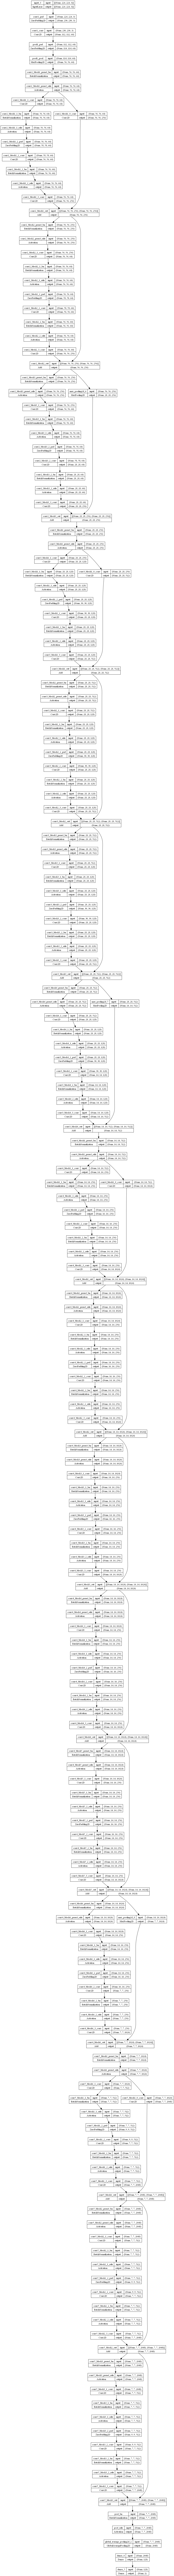

In [232]:
plot_model(res_model, to_file=FILES_GENERATED + MODEL_PNG, show_shapes=True, show_layer_names=True)
display(Image.open(FILES_GENERATED + MODEL_PNG))

# **Create a callback that saves the model's weights**

In [ ]:
checkpoint_path = CHECKPOINT_DIR + "cp-{epoch:04d}.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

# **Create a callback allowing to save the best performing model**

In [ ]:
# Create a callback allowing to save the best performing model
checkpoint = ModelCheckpoint(MODEL_SAVED, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# **train the model**

In [ ]:
history = res_model.fit(train,epochs=30, 
                    validation_data=validation,
                    steps_per_epoch=100,
                    callbacks=[early_stopping,lr, checkpoint, cp_callback],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.8584
Epoch 1: val_loss improved from inf to 1.26765, saving model to saved_model\model.h5
100/100 [==============================] - 107s 1s/step - loss: 0.3317 - accuracy: 0.8584 - val_loss: 1.2676 - val_accuracy: 0.5294 - lr: 0.0010
Epoch 2/30
 59/100 [================>.............] - ETA: 42s - loss: 0.2288 - accuracy: 0.9052
Epoch 2: saving model to checkpoints\cp-0002.ckpt
100/100 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9112
Epoch 2: val_loss improved from 1.26765 to 0.65625, saving model to saved_model\model.h5
100/100 [==============================] - 105s 1s/step - loss: 0.2191 - accuracy: 0.9112 - val_loss: 0.6562 - val_accuracy: 0.8824 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9222
Epoch 3: val_loss did not improve from 0.65625
100/100 [==============================] - 103s 1s/step - loss: 0

# **Accuracy & Loss each epochs**

Text(0, 0.5, 'Loss')

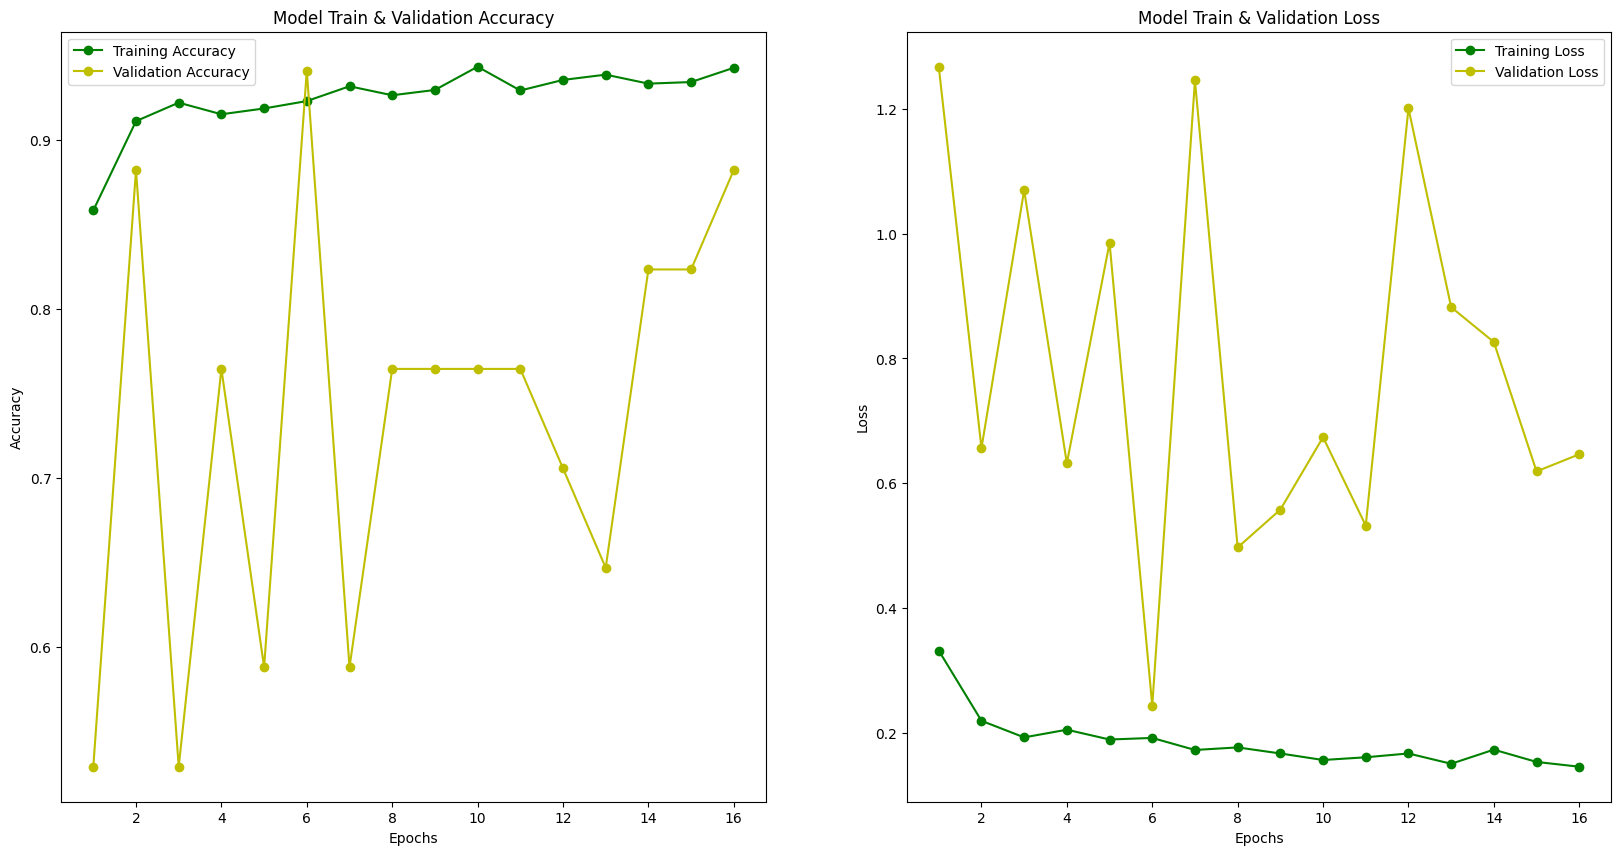

In [221]:
#Plot the training artifacts
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs, train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

# **Model evaluation with training and testing data**
<p> Difference between training accuracy and test accuracy. Training accuracy means that identical images are used both for training and testing, while test accuracy represents that the trained model identifies independent images that were not used in training. </p>

<p> The training loss indicates how well the model is fitting the training data, while the test loss indicates how well the model fits new data </p>

In [ ]:
# Evaluating the model on train and test

score = res_model.evaluate(train)
print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = res_model.evaluate(test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 141s 864ms/step - loss: 0.1560 - accuracy: 0.9342
Train Loss:  0.15601372718811035
Train Accuracy:  0.9342408180236816
312/312 [==============================] - 25s 81ms/step - loss: 0.2248 - accuracy: 0.9135

Test loss:  0.22479984164237976
Test Accuracy:  0.9134615659713745


<p> This output shows the evaluation metrics, including loss and accuracy, for the pneumonia detection AI model on both the training and test datasets. The model has achieved high accuracy levels on both datasets, indicating its potential for accurate pneumonia detection using X-ray images. </p>

# **Get the confusion matrix**
<p> A confusion matrix is a table that is used to define the performance of a classification algorithm. A confusion matrix visualizes and summarizes the performance of a classification algorithm. </p>

In [233]:
val_images = []
val_labels = []
pred_labels = []

for file in os.listdir(test_directory + 'PNEUMONIA'):
  img = tf.keras.utils.load_img(
      test_directory + 'PNEUMONIA' + "/" +file, target_size=(IMAGE_SIZE, IMAGE_SIZE)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = res_model.predict(img_array, verbose=None)
  score = tf.nn.softmax(predictions[0])

  val_images.append(file)
  val_labels.append(1)  # pneumonia
  pred_labels.append(np.argmax(score))

for file in os.listdir(test_directory + 'NORMAL'):
  img = tf.keras.utils.load_img(
      test_directory + 'NORMAL' + "/" +file, target_size=(IMAGE_SIZE, IMAGE_SIZE)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = res_model.predict(img_array, verbose=None)
  score = tf.nn.softmax(predictions[0])

  val_images.append(file)
  val_labels.append(0)  # normal
  pred_labels.append(np.argmax(score))

conf_mat = confusion_matrix(val_labels, pred_labels)
print(conf_mat)

[[121 113]
 [  3 387]]


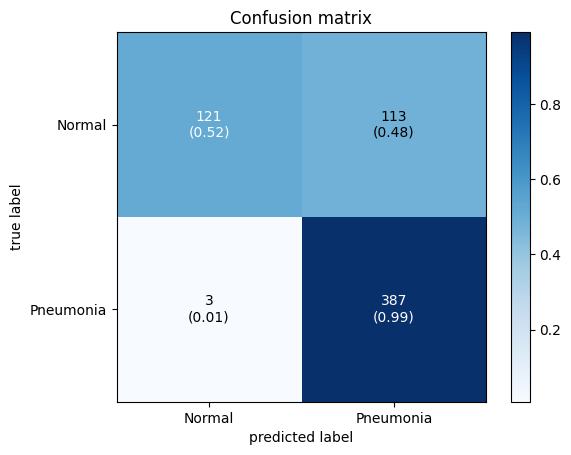

In [222]:
# Get the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)

plt.show()

# **Calcul precision of model**
<div>
<p> To calculate the precision from the given confusion matrix, we need to first identify the number of true positives (TP) and false positives (FP) in the predictions. In this case: </p>

<p> 
TP = 387
FP = 113
</p>

<h3> The confusion matrix represents the following: <h3>

<div style="text-align: left;">
  <table>
    <tr>
      <th></th>
      <th>Actual Positive</th>
      <th>Actual Negative</th>
    </tr>
    <tr>
      <td>Predicted Positive</td>
      <td>True Positive (TP) = 387</td>
      <td>False Positive (FP) = 113</td>
    </tr>
    <tr>
      <td>Predicted Negative</td>
      <td>False Negative (FN) = 3</td>
      <td>True Negative (TN) = 121</td>
    </tr>
  </table>
</div>

<p> Using the formula for precision: </p>
<code style="font-size: 16px;">  Precision = TP / (TP + FP) = 387 / (387 + 113) = 0.774 or 77.4% </code>

<h4> Therefore, the precision of the model based on the given confusion matrix is 77.4%. </h4>
</div>


# **Conclusion**

<p>Overall, the AI model we developed for pneumonia detection using X-ray images has shown promising results in terms of accuracy and precision. The model achieved a training accuracy of 93.42% and a test accuracy of 91.35%, indicating its potential as an effective diagnostic tool. Additionally, the precision of the model is calculated to be approximately 77.4%, meaning that it correctly identifies positive cases of pneumonia in around 77.4% of cases. While there is always room for improvement, these results demonstrate that the model can be useful in medical diagnosis and can be further optimized to improve its performance.</p>


<p> In conclusion, the development of an AI system for pneumonia detection is a significant step towards enhancing medical diagnosis and treatment. This IPYNB file provides an overview of how such a system can be built using deep learning techniques and convolutional neural networks. With high accuracy rates and the ability to analyze vast amounts of data quickly, this AI system has the potential to revolutionize pneumonia diagnosis and management. However, further testing and validation are needed to ensure its effectiveness in clinical settings. Overall, this pneumonia detection AI offers promising opportunities for improving healthcare and saving lives. </p>